In [1]:
import os
from shutil import copy
import numpy as np
import torch
import cv2
import faiss

from src.cnn_feature_extractor import FeatureExtractor  # out feature extractor

# Setting up required variables

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
imgs_folder = 'database_T2/'  # input folder with images
cnn_feature_extractor = FeatureExtractor(device=device)

self.device='cuda:0'


# Main class

In [3]:
class ImageSeparator:
    def __init__(
            self,
            feature_extractor: torch.nn.Module,
            device: str,
            threshold: float
    ):
        self.feature_extractor = feature_extractor  # model for feature extraction
        self.device = device
        self.threshold = threshold  # distance threshold for searching closest vectors

    def separate(self, img_dir: str, output_dir: str) -> None:
        """
        :param img_dir:
        :param output_dir:
        :return: None

        main method for separating images in folder to N buckets based on there "similarity"
        """

        vectors, id_map = self.extract_vectors(img_dir=img_dir)
        index = self.create_index(vector_dimensions=vectors[0].shape[0])
        index.add(vectors)

        free_images: set = set(id_map.values())
        bucket: int = 0
        bucket_info: dict = {}

        grouped_img_dir = output_dir
        if not os.path.exists(grouped_img_dir):
            os.mkdir(grouped_img_dir)

        for v in vectors:
            distances, indexes = index.search(np.expand_dims(v, axis=0), 10)  # search with just one v (could be butch)
            distances = distances[0][0:]
            indexes = indexes[0][0:]
            valid = np.argwhere(distances < self.threshold)
            indexes = indexes[valid].tolist()
            img_names = [id_map[i[0]] for i in indexes]
            img_names = [i for i in img_names if i in free_images]
            n_sim_imgs = len(img_names)

            if n_sim_imgs > 1:
                bucket += 1
                bucket_info[bucket] = []
                bucket_path = os.path.join(grouped_img_dir, str(bucket))
                if not os.path.exists(bucket_path):
                    os.mkdir(bucket_path)
                for i in img_names:
                    free_images.remove(i)
                    dst = os.path.join(bucket_path, i.split("/")[-1])
                    copy(i, dst)
                    bucket_info[bucket].append(dst)
        return bucket_info

    def extract_vectors(self, img_dir: str):
        """
        :param img_dir:
        :return: vectors, id_to_img_map:

        method for extracting feature vectors from images in a given folder
        """

        id_to_img_map: dict = {}
        vectors: list = []

        for i, img in enumerate(os.listdir(img_dir)):
            img_path = os.path.join(img_dir, img)
            id_to_img_map[i] = img_path
            bgr_img = cv2.imread(img_path)
            vector = cnn_feature_extractor.extract(bgr_img)
            vectors.append(vector)

        vectors = np.vstack(vectors)
        return vectors, id_to_img_map

    def create_index(self, vector_dimensions: int) -> faiss.Index:
        return faiss.IndexFlatL2(vector_dimensions)


In [4]:
img_sep = ImageSeparator(feature_extractor=cnn_feature_extractor, device=device, threshold=110.0)

# Separation of images

In [5]:
info = img_sep.separate(img_dir="database_T2/", output_dir="grouped/")

In [6]:
info[1]  # dictionary with image passes separate on N buckets

['grouped/1/197.jpg', 'grouped/1/198.jpg']

# Visualization of a few examples (all images saved in folder 'grouped')

In [7]:
from matplotlib import pyplot as plt
def display_one_bucket(bucket_number: int, info: dict):

    fig = plt.figure(figsize=(6, 6))
    for i, image_path in enumerate(info[bucket_number]):
        img = plt.imread(image_path)
        fig.add_subplot(1, len(info[bucket_number]), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(str(bucket_number))

plt.show()

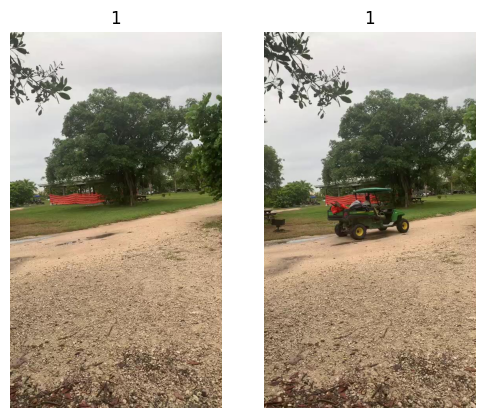

In [8]:
display_one_bucket(1, info)

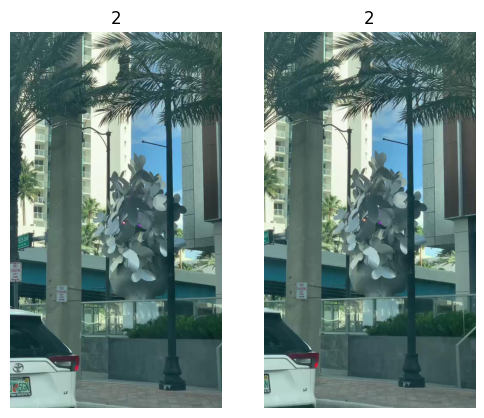

In [9]:
display_one_bucket(2, info)

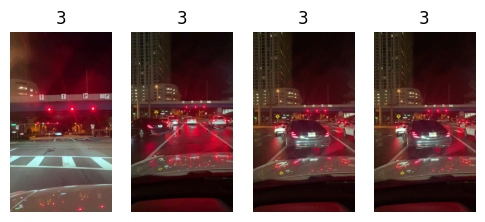

In [10]:
display_one_bucket(3, info)

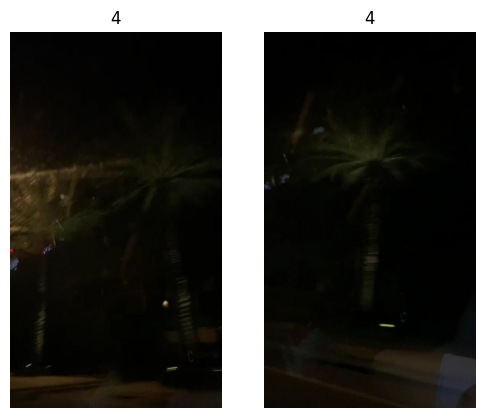

In [11]:
display_one_bucket(4, info)

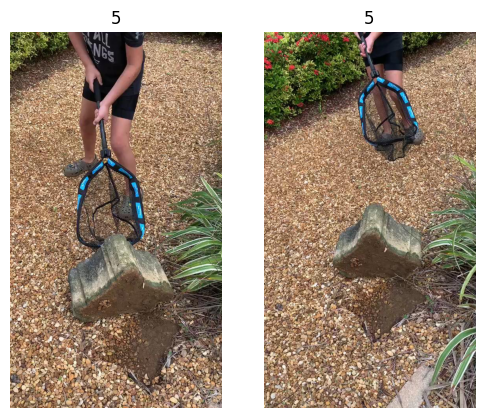

In [12]:
display_one_bucket(5, info)